In [ ]:
import pymc3 as pm
import numpy
import scipy
import scipy.stats

### Making sure this works

Okay, let's 

Note that it does not matter how the data is organized, so long as the function can interpret it. Here, the data is passed as a dictionary, but an ndarray could also have been used.

Now let's generate 200 data points from a simple linear model:

$$x \sim normal(0, 5)$$

$$\epsilon \sim normal(0,2)$$

$$y=2x+5+\epsilon$$




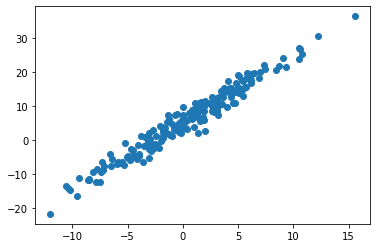

In [ ]:
import scipy.stats
from matplotlib import pyplot
import seaborn

x=scipy.stats.norm.rvs(0, 5, size=200)
err=scipy.stats.norm.rvs(0, 2, size=200)
slope=2
intercept=5
y=x*slope+intercept +err
pyplot.scatter(x,y)
data={'x':x,
     'y':y}

Okay, now well wrap the cost function and the data in the ```CustomCost``` class

In [ ]:
from gradless import optimizers, costs, gradient, updates

In [ ]:
def MSE(theta, data):
    x,y=data['x'], data['y']
    y_pred=theta[0]*x+theta[1]
    return numpy.mean((y-y_pred)**2)

In [ ]:
mse_cost=costs.Model(MSE, data)
starts=numpy.array([-9,-9])
update_rule=updates.NADAM( beta1=.9)

In [ ]:
opt=optimizers.GradientDescent(starts,mse_cost,update_rule,param_stepsize=.5, param_stepdecay=0, param_decay_offset=0, 
                 grad_stepsize=1, grad_stepdecay=.2, )

In [ ]:
opt.update_params(gradient_reps=100, max_step=1)
for i in range(5000):
    opt.update_params(gradient_reps=3, max_step=1)
#     elbo.sample_rvs()

In [ ]:
X,Y,Z=[],[],[]
for slope in numpy.arange(-15, 15,.2):

    for intercept in numpy.arange(-15, 15,.2):
        Y.append(intercept)
        X.append(slope)
        Z.append(mse_cost.evaluate([slope,intercept]))


In [ ]:
theta_hist=numpy.array(opt.theta_hist)

(-15.0, 15.0)

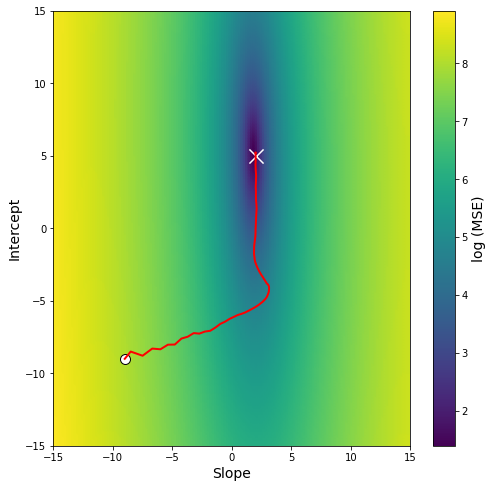

In [ ]:
pyplot.figure(figsize=(8,8))
sc=pyplot.scatter(X,Y, c=numpy.log(Z), zorder=-1)
pyplot.scatter(starts[0], starts[1], c='white', edgecolor='black', s=100)
pyplot.plot(theta_hist[:,0],theta_hist[:,1], c='red', lw=2)
pyplot.scatter(2, 5, marker='x', c='white', s=200)

cbar=pyplot.colorbar(sc)
cbar.set_label('log (MSE)', size=14)
pyplot.ylabel('Intercept', size=14)
pyplot.xlabel('Slope', size=14)
pyplot.xlim(-15,15)
pyplot.ylim(-15,15)

In [ ]:
ndim=100
means=scipy.stats.norm.rvs(0, 10, size=ndim)
sd=2.**scipy.stats.norm.rvs(3,1.5 , size=ndim)
data=scipy.stats.norm.rvs(means, sd, size=(100,ndim))


In [ ]:
starts=scipy.stats.norm.rvs(0,3, size=means.shape[0]+sd.shape[0])

In [ ]:
def evidence(theta, data):
    #priors
    mu=theta[::2]
    sd=theta[1::2]
    mu_prior=scipy.stats.norm.logpdf(mu, 0, 10).sum()
    sd_prior=scipy.stats.norm.logpdf(sd, 0, 10).sum()
    
    loglk=scipy.stats.norm.logpdf(data, mu,2.**sd).sum()
    return -(mu_prior+sd_prior+loglk)

In [ ]:
print (evidence(starts, data))

1031747349.1118141


In [ ]:
post_proxy=costs.Model(evidence, data)

update_rule=updates.NADAM( beta1=.9)

In [ ]:
print (starts.shape)

(200,)


In [ ]:
opt=optimizers.GradientDescent(starts,post_proxy,update_rule,gradient.SPSAGradient([0,1]*ndim),param_stepsize = .25, param_stepdecay = .2, param_decay_offset = 20, 
                               grad_stepsize = 2, grad_stepdecay = .2, )

In [ ]:
# grad_test=gradient.SPSAGradient()

In [ ]:
# grad_test.evaluate(post_proxy, starts,1)

In [ ]:
from tqdm import tqdm

In [ ]:
opt.update_params(gradient_reps=100, max_step=.05)
for i in tqdm(range(100000)):
    opt.update_params(gradient_reps=1, block_val=1.2, max_step=.05 )
#     elbo.sample_rvs()

100%|██████████| 100000/100000 [05:19<00:00, 312.53it/s]


In [ ]:
len(opt.theta_hist)

100002

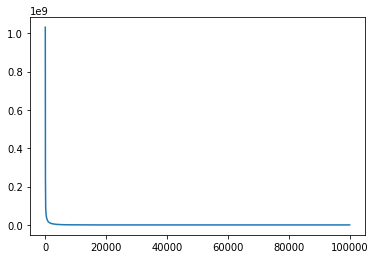

In [ ]:
pyplot.plot(opt.cost_history)

In [ ]:
theta_hist=numpy.array(opt.theta_hist)

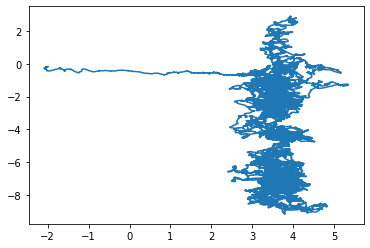

In [ ]:
pyplot.plot(theta_hist[:,0], theta_hist[:,2])

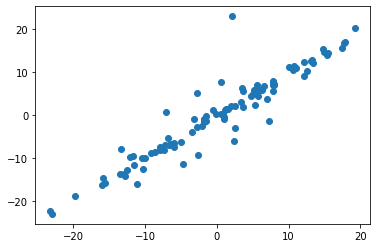

In [ ]:
pyplot.scatter(theta_hist[-1,::2], means)

In [ ]:
numpy.argmax(theta_hist[-1,::2]-means)

11

In [ ]:
# data[:,13]

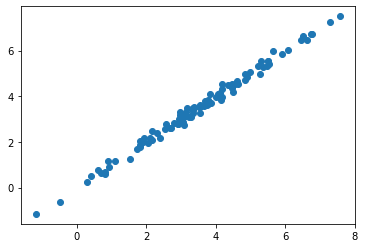

In [ ]:
pyplot.scatter(theta_hist[-1,1::2], numpy.log2(sd))

In [ ]:
with pm.Model() as model:
    mu=pm.Normal('mu',0,10, shape=ndim)
    std=2.**pm.Normal('sd',0,10, shape=ndim)
    obs=pm.Normal('obs',mu, std, observed=data)

In [ ]:
with model:
    trace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [ ]:
mean_mu=trace['mu'].mean(0)
mean_std=trace['mu'].std(0)
sd_mu=trace['sd'].mean(0)
sd_std=trace['sd'].std(0)

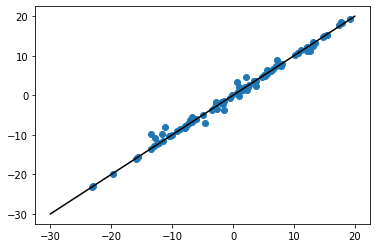

In [ ]:
pyplot.scatter(theta_hist[-1,::2], (mean_mu))
pyplot.plot([-30,20],[-30,20], color='black')

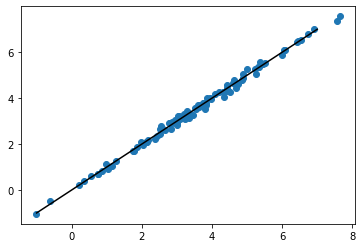

In [ ]:
pyplot.scatter(theta_hist[-1,1::2], (sd_mu))
pyplot.plot([-1,7],[-1,7], color='black')

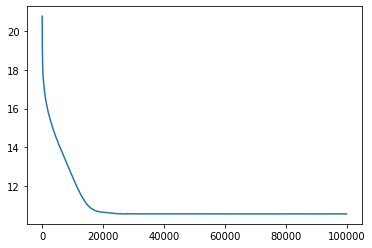

In [ ]:
pyplot.plot(numpy.log(opt.cost_history))

### Advi

In [ ]:
starts=numpy.hstack([opt.theta, [3.]*2*ndim] )
# starts[ndim*2:]=2.

In [ ]:
print (starts.shape)

(400,)


In [ ]:
def advi_evidence(theta, data):
    #priors
    mu=theta[::2]
    sd=theta[1::2]
    mu_prior=scipy.stats.norm.logpdf(mu, 0, 10).sum()
    sd_prior=scipy.stats.norm.logpdf(sd, 0, 10).sum()
    
    loglk=scipy.stats.norm.logpdf(data, mu,2.**sd).sum()
    return (mu_prior+sd_prior+loglk)

In [ ]:
# print (evidence(sELBOts, data))

In [ ]:
import gradless.costs

In [ ]:
print (starts.shape)

(400,)


In [ ]:
post_proxy=gradless.costs.ELBO(advi_evidence, data, param_num=2*ndim)
spsa_grad=gradient.SPSAGradient([0,1]*ndim+[2,3]*ndim)
update_rule=updates.NADAM(beta1=.99 )
advi_opt=optimizers.GradientDescent(starts,
                               cost = post_proxy,
                               update = update_rule,
                               gradient = spsa_grad,                                
                               param_stepsize = .25, param_stepdecay = .3, param_decay_offset = 20, 
                               grad_stepsize = 1, grad_stepdecay = .2, )

In [ ]:
# opt.cost.sample_rvs()
# step=optimizers.initialize_param_step(opt)
# opt.cost.sample_rvs()
# step=optimizers.initialize_param_step(opt)

In [ ]:
opt.param_stepsize

0.25

In [ ]:
# opt.t=1
# ghat=opt.gradient.evaluate(opt.cost, starts,opt.grad_stepsize, gradient_reps=10 )

In [ ]:
# ghat

In [ ]:
from tqdm import tqdm

In [ ]:
advi_opt.update_params(gradient_reps=100, update_rvs=True, max_step=.01)
advi_opt.update_params(gradient_reps=100, update_rvs=True, max_step=.01)
# opt.cost.sample_rvs()
for i in tqdm(range(5000)):
#     if i>100:
#         cost_std=numpy.std(opt.cost_history[-100:])
#         cost_mean=numpy.mean(opt.cost_history[-100:])
#         block=(cost_mean+2*cost_std)/cost_mean
#     else:
#         block=numpy.inf
    advi_opt.update_params(gradient_reps=1, update_rvs=True, max_step=.01)
#     opt.cost.sample_rvs()
#     elbo.sample_rvs()

100%|██████████| 5000/5000 [00:31<00:00, 157.16it/s]


In [ ]:

# opt.cost.sample_rvs()
for i in tqdm(range(100000)):
#     if i>100:
#         cost_std=numpy.std(opt.cost_history[-100:])
#         cost_mean=numpy.mean(opt.cost_history[-100:])
#         block=(cost_mean+2*cost_std)/cost_mean
#     else:
#         block=numpy.inf
    advi_opt.update_params(gradient_reps=1, update_rvs=True, max_step=.05)
#     opt.cost.sample_rvs()
#     elbo.sample_rvs()

100%|██████████| 100000/100000 [10:41<00:00, 155.90it/s]


In [ ]:

# opt.cost.sample_rvs()
for i in tqdm(range(50000)):
#     if i>100:
#         cost_std=numpy.std(opt.cost_history[-100:])
#         cost_mean=numpy.mean(opt.cost_history[-100:])
#         block=(cost_mean+2*cost_std)/cost_mean
#     else:
#         block=numpy.inf
    advi_opt.update_params(gradient_reps=1, update_rvs=True, max_step=.05)
#     opt.cost.sample_rvs()
#     elbo.sample_rvs()

100%|██████████| 50000/50000 [05:19<00:00, 156.64it/s]


In [ ]:
# # opt.update_params(gradient_reps=100, update_rvs=True)
# # opt.cost.sample_rvs()
# for i in tqdm(range(50000)):
# #     if i>100:
# #         cost_std=numpy.std(opt.cost_history[-100:])
# #         cost_mean=numpy.mean(opt.cost_history[-100:])
# #         block=(cost_mean+2*cost_std)/cost_mean
# #     else:
# #         block=numpy.inf
#     opt.update_params(gradient_reps=1, update_rvs=True)
# #     opt.cost.sample_rvs()
# #     elbo.sample_rvs()

100%|██████████| 50000/50000 [08:00<00:00, 104.12it/s]


In [ ]:
# # opt.update_params(gradient_reps=100, update_rvs=True)
# # opt.cost.sample_rvs()
# for i in tqdm(range(50000)):
# #     if i>100:
# #         cost_std=numpy.std(opt.cost_history[-100:])
# #         cost_mean=numpy.mean(opt.cost_history[-100:])
# #         block=(cost_mean+2*cost_std)/cost_mean
# #     else:
# #         block=numpy.inf
#     opt.update_params(gradient_reps=1, update_rvs=True)
# #     opt.cost.sample_rvs()
# #     elbo.sample_rvs()

100%|██████████| 50000/50000 [07:57<00:00, 104.66it/s]


In [ ]:
# # opt.update_params(gradient_reps=100, update_rvs=True)
# # opt.cost.sample_rvs()
# for i in tqdm(range(50000)):
# #     if i>100:
# #         cost_std=numpy.std(opt.cost_history[-100:])
# #         cost_mean=numpy.mean(opt.cost_history[-100:])
# #         block=(cost_mean+2*cost_std)/cost_mean
# #     else:
# #         block=numpy.inf
#     opt.update_params(gradient_reps=1, update_rvs=True)
# #     opt.cost.sample_rvs()
# #     elbo.sample_rvs()

100%|██████████| 50000/50000 [07:56<00:00, 104.96it/s]


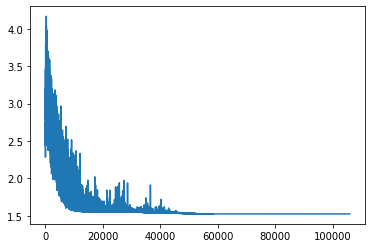

In [ ]:
pyplot.plot(numpy.log(advi_opt.cost_history))

In [ ]:
theta_hist=numpy.array(advi_opt.theta_hist)

In [ ]:
# theta_hist[-1]-theta_hist[-2]

In [ ]:
theta=numpy.array(advi_opt.theta)

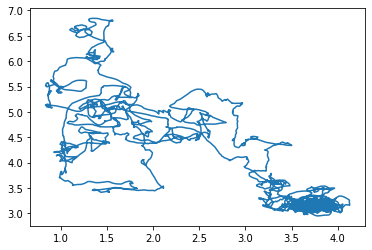

In [ ]:
pyplot.plot(theta_hist[:,0], theta_hist[:,1])

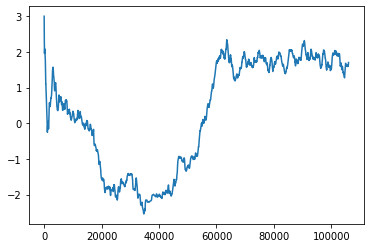

In [ ]:
pyplot.plot(theta_hist[:,-4])

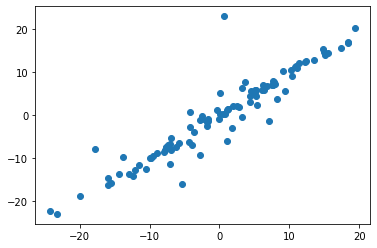

In [ ]:
pyplot.scatter( theta[:2*ndim][::2],means)

<ErrorbarContainer object of 3 artists>

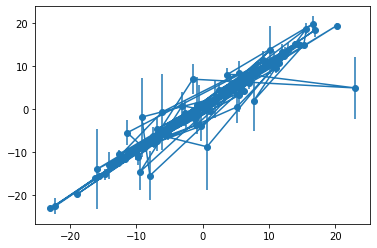

In [ ]:

yerr=2.**theta_hist[-1,2*ndim:][::2]
pyplot.errorbar( means,theta_hist[-1,:2*ndim][::2], yerr=yerr ,marker='o')

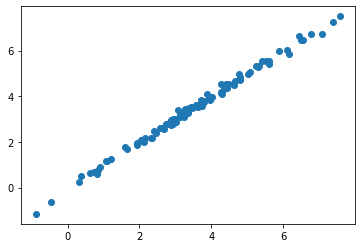

In [ ]:
pyplot.scatter( theta_hist[-1,:2*ndim][1::2],numpy.log2(sd))

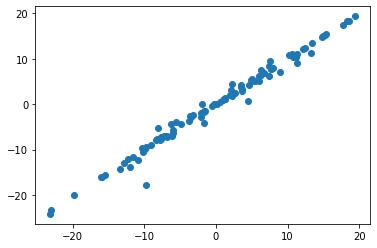

In [ ]:
pyplot.scatter(mean_mu, theta_hist[-1,:2*ndim][::2])

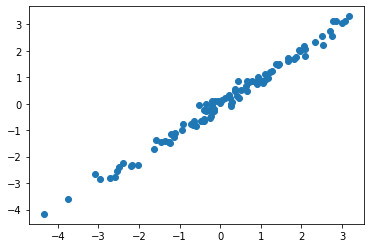

In [ ]:
pyplot.scatter(numpy.log2(mean_std),theta_hist[-1,2*ndim:][::2])

[]

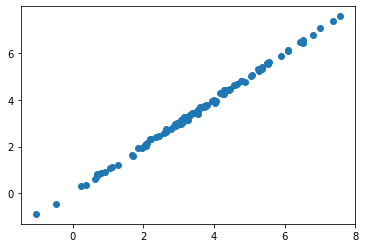

In [ ]:
pyplot.scatter(sd_mu, theta_hist[-1,:2*ndim][1::2])
pyplot.plot()

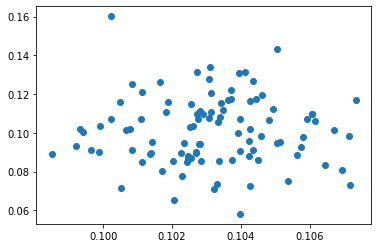

In [ ]:
pyplot.scatter((sd_std),2.**theta_hist[-1,2*ndim:][1::2])

In [ ]:
max_diff=numpy.argmax(numpy.abs( mean_mu- theta_hist[-1,:2*ndim][::2]))

In [ ]:
2.**theta_hist[-1,:2*ndim][1::2][max_diff]

169.1444231756477

In [ ]:
mean_std[max_diff]

8.409788158194566

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


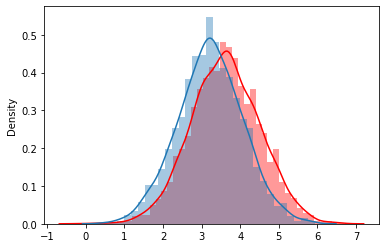

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


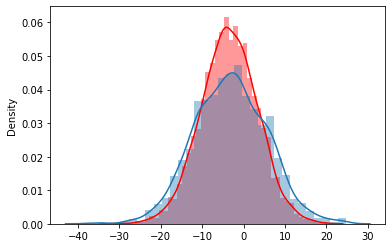

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


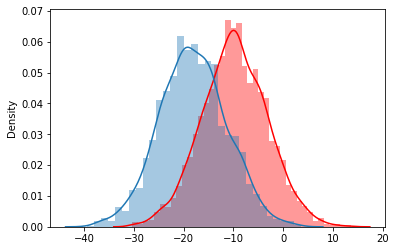

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


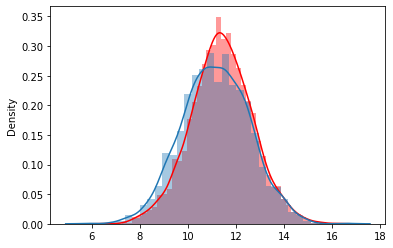

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


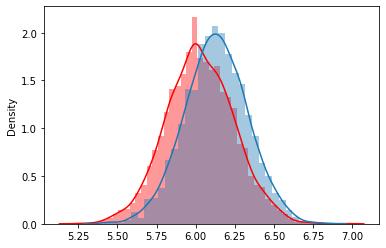

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


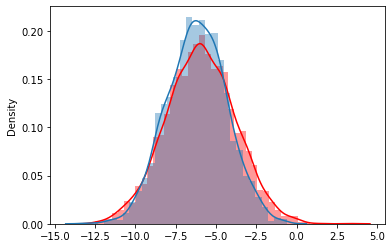

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


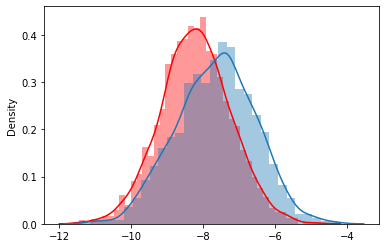

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


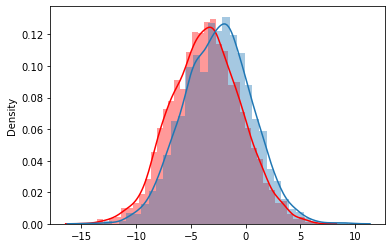

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


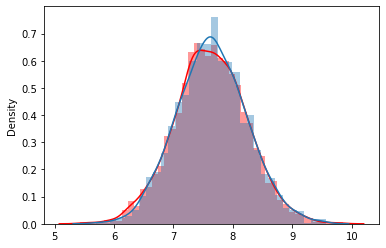

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


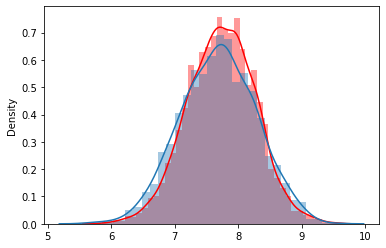

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


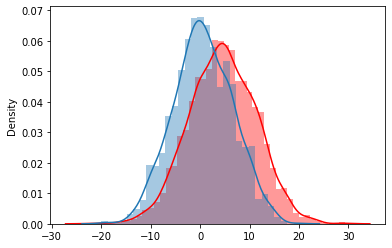

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


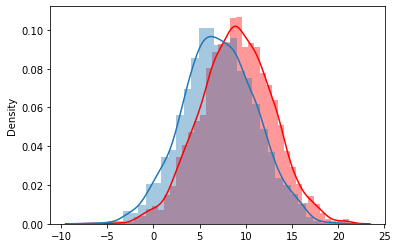

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


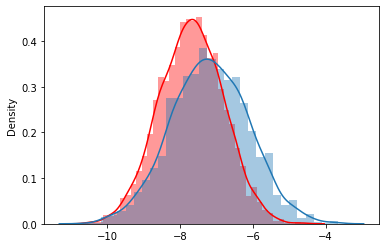

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


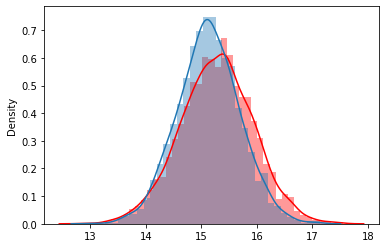

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


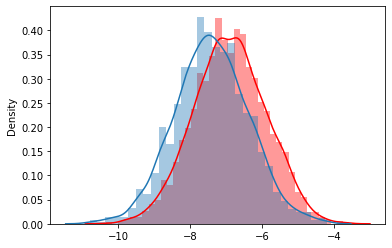

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


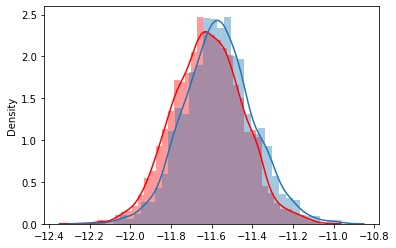

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


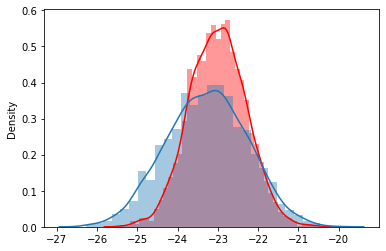

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


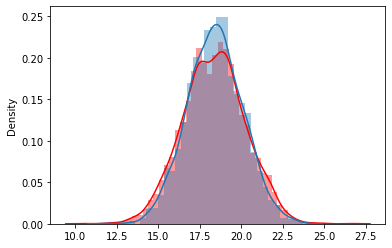

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


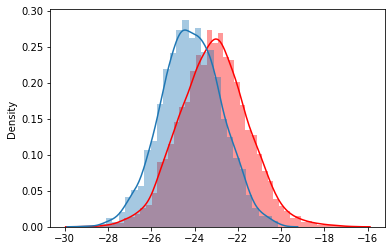

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


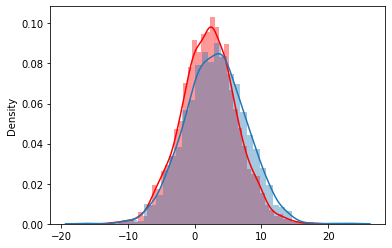

In [ ]:
for i in range(20):
    seaborn.distplot(trace['mu'][:,i],color='red')
    seaborn.distplot(scipy.stats.norm.rvs(theta_hist[-1,:2*ndim][::2][i],
                                          2.**theta_hist[-1,2*ndim:][::2][i],
                                          size=2000
                                         ))
    pyplot.show()

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


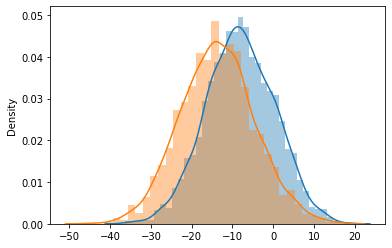

In [ ]:
seaborn.distplot(trace['mu'][:,max_diff])
seaborn.distplot(scipy.stats.norm.rvs(theta_hist[-1,:2*ndim][::2][max_diff],
                                      2.**theta_hist[-1,2*ndim:][::2][max_diff],
                                      size=2000
                                     ))

/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mpm289/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


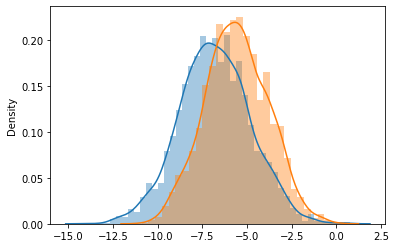

In [ ]:
seaborn.distplot(trace['mu'][:,max_diff-2])
seaborn.distplot(scipy.stats.norm.rvs(theta_hist[-1,:2*ndim][::2][max_diff-2],
                                      2.**theta_hist[-1,2*ndim:][::2][max_diff-2],
                                      size=2000
                                     ))

### A simple simulation based model

